In [1]:
# import the required packages
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.signal import convolve2d, decimate

# define the haar2d function for wavelet decomposition
def haar2d(im, lvl):
  """
  Computing the 2D discrete Haar wavelet transform of a given ndarray im

  Parameters:
  im: ndarray, an array representing the image
  lvl: int, an integer representing the level of wavelet decomposition

  Returns: 
  out: ndarray, an array representing Haar wavelet coefficients with lvl level. It has the same shape as im
  """
  # initialize a wavelet coefficient matrices with the same initial size as the image, that we will continuously update with values from our convolve2d and downsampling.
  out = np.zeros([len(im), len(im)])
  # initialize the length of the image, which will be adjused within the for loop for required number of levels
  im_len = len(im)
  
  # Loop for the required number of levels
  for i in range(lvl):
    # run convolve2d with the reverse order filter banks for wavelet decomposition, use mode='same' to keep same input length as im and use circular convolution for boundary='wrap'
    im_h = convolve2d(im, H_rev, mode='same', boundary='wrap')
    im_g1 = convolve2d(im, G1_rev, mode='same', boundary='wrap')
    im_g2 = convolve2d(im, G2_rev, mode='same', boundary='wrap')
    im_g3 = convolve2d(im, G3_rev, mode='same', boundary='wrap')

    # run the downsampling by taking a step size of 2, taking note of the starting index for downsampling for row & column to be index at 1 (2nd element)
    im_h = im_h[1::2, 1::2]
    im_g1 = im_g1[1::2, 1::2]
    im_g2 = im_g2[1::2, 1::2]
    im_g3 = im_g3[1::2, 1::2]
    
    # update the output ndarray with the current iteration's wavelet coefficients at 4 segments as in question
    # go by rows first (y-axis), followed by columns (x-axis) by indexing.
    out[0:im_len//2 , 0:im_len//2] = im_h # Scale Coefficient - H is on the top left as in the question paper 
    out[0:im_len//2 , im_len//2:im_len] = im_g1 # Wavelet Coefficient - G1 is on the right of H as in lecture notes
    out[im_len//2:im_len , 0:im_len//2] = im_g2 # Wavelet Coefficient - G2 is directly below H as in lecture notes
    out[im_len//2:im_len , im_len//2:im_len] = im_g3 # Wavelet Coefficient - G3 is diagonally opposite H as in lecture notes

    # Now we need to prepare for the next iteration, if any, if lvl > 1
    # In decomposition, the subsequent wavelet decompositions are performed on im_h as shown in lecture notes
    # Update im to be im_h
    im = im_h

    # Update our length to be divided by 2
    im_len //= 2

  return out



# Define the reconstruction function
def ihaar2d(coef,lvl):
# Computing an image in the form of ndarray from the ndarray coef which represents its DWT coefficients.
# Parameters: 
#   coef: ndarray   An array representing 2D Haar wavelet coefficients
#   lvl: integer.   An integer representing the level of wavelet decomposition
#  Returns:
#   out: ndarray.   An array representing the image reconstructed from its Haar wavelet coefficients.

  # Start with the smallest set of images in our coefficient matrix by finding the length
  im_len_smallest = len(coef)//2**(lvl-1)

  # locate s.x (im_h_coef) outside the for loop, as we will get im_h_coef after summing up the rest of the coefficients for the rest of the loop.
  out = coef[0:im_len_smallest//2, 0:im_len_smallest//2]

  # Loop through the levels for wavelet reconstruction
  for i in range(lvl):
    # locate our locate our w.x.1, w.x.2, w.x.3 from our coefficient matrix with im_len_smallest
    im_g1_coef = coef[0:im_len_smallest//2 , im_len_smallest//2:im_len_smallest]
    im_g2_coef = coef[im_len_smallest//2:im_len_smallest, 0:im_len_smallest//2]
    im_g3_coef = coef[im_len_smallest//2:im_len_smallest , im_len_smallest//2:im_len_smallest]

    # upsampling by a factor of 2, by initializing double the size of the smallest length
    h_coef_up = np.zeros([im_len_smallest, im_len_smallest])
    g1_coef_up = np.zeros([im_len_smallest, im_len_smallest])
    g2_coef_up = np.zeros([im_len_smallest, im_len_smallest])
    g3_coef_up = np.zeros([im_len_smallest, im_len_smallest])

    # updating our matrix at step size of 2 intervals to complete upsizing
    # starting index = 0 for 
    h_coef_up[0::2, 0::2] = out
    g1_coef_up[0::2, 0::2] = im_g1_coef
    g2_coef_up[0::2, 0::2] = im_g2_coef
    g3_coef_up[0::2, 0::2] = im_g3_coef

    # Perform convolve2d with the 2D Haar wavelet filter banks
    out = convolve2d(h_coef_up, H, mode='same', boundary='wrap')
    im_g1_coef = convolve2d(g1_coef_up, G1, mode='same', boundary='wrap')
    im_g2_coef = convolve2d(g2_coef_up, G2, mode='same', boundary='wrap')
    im_g3_coef = convolve2d(g3_coef_up, G3, mode='same', boundary='wrap')

    # Perform summation to get im_h_coef for the current larger cell
    out = out + im_g1_coef + im_g2_coef + im_g3_coef
    
    # Update for next iteration, double the im_len_smallest
    im_len_smallest *= 2
    

  # After the end of the final loop, we will obtain our perfectly reconstructed image result.

  return out


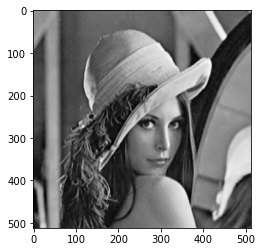

In [2]:
# Open the image that is required to be processed on using PIL
im = np.array(Image.open('image_512.png'))

# Plot image for viewing, gray-scale image
plt.subplot(1,1,1); plt.imshow(im, cmap='gray')

In [4]:
# Defining the filter banks for 2D Haar wavelet transform - required for wavelet reconstruction
H = np.array([[1, 1], [1, 1]]) / 2
G1 = np.array([[1, 1], [-1, -1]]) / 2
G2 = np.array([[1, -1], [1, -1]]) / 2
G3 = np.array([[1, -1], [-1, 1]]) / 2

# Defining the reverse order filter banks for 2D Haar wavelet transform - required for wavelet decomposition
# reverse in both the up&down and left&right direction to obtain the reverse filter banks for 2D Haar Wavelet
H_rev = np.fliplr(np.flipud(H))
G1_rev = np.fliplr(np.flipud(G1))
G2_rev = np.fliplr(np.flipud(G2))
G3_rev = np.fliplr(np.flipud(G3))


In [78]:
wavelet_coefficients = haar2d(im,4)

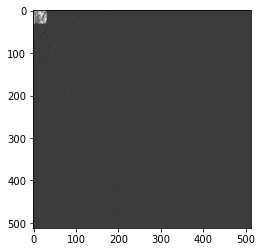

In [6]:
plt.imshow(wavelet_coefficients,cmap='gray')

In [7]:
recon_image = ihaar2d(wavelet_coefficients, 4)

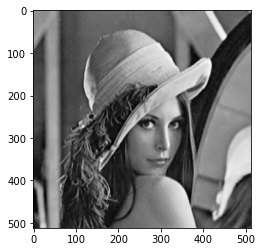

In [8]:
plt.imshow(recon_image, cmap='gray')

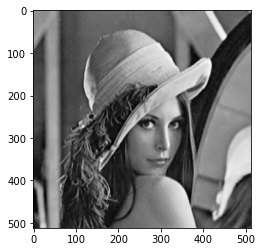

In [9]:
plt.imshow(im, cmap='gray')